<a href="https://colab.research.google.com/github/BaishaliChetia/CapsNet-Keras/blob/master/capsMnistPrunedQuantized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original implementation at:

https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb

Geron's model doesn't use the keras functional API. In the keras functional API, you don't need to give the batchsize. 

When you print the model, you get this:

```
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 20, 20, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 1, 1152, 8)        0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 1, 1152, 8)        0         
_________________________________________________________________
Total params: 5,329,664
Trainable params: 5,329,664
Non-trainable params: 0
```

Notice that the Input-layer has shape (None, 28, 28, 1), but we only specified (28, 28, 1). It added None implicitly and that takes care of the batch.

So for anywhere Geron uses the batch size explicitly, you don't need to do anything and tensorflow will take care of.

Also note that tensorflow 1 APIs are still provided with the compat layer. I used the reduce_sum from TF1 in the squash layer, that allowed me to use Geron's code.

Documentation on how to migrate from TF1 to TF2 can be found here:

https://www.tensorflow.org/guide/migrate


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow.keras as K
#import tensorflow_model_optimization as tfmot

In [3]:
pip install -q tensorflow-model-optimization

     |████████████████████████████████| 211 kB 5.1 MB/s 


In [4]:
import tensorflow_model_optimization as tfmot

In [6]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8
caps2_n_caps = 10
caps2_n_dims = 16

tf.random.set_seed(500000)

In [31]:
#class SquashLayer(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
class SquashLayer(K.layers.Layer):
  def __init__(self, axis=-1, **kwargs):
    super(SquashLayer, self).__init__(**kwargs)
    self.axis = axis
    
  def build(self, input_shapes):
    pass

  """
  def get_prunable_weights(self):
    return []
  """

  def call(self, inputs):
    EPSILON = 1.0e-9
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector

  def get_config(self):
    config = super(SquashLayer, self).get_config()
    config.update({"axis": self.axis})
    return config

 
#class SafeNorm(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
class SafeNorm(K.layers.Layer):
  
  def __init__(self, axis=-1, keep_dims = False,  **kwargs):
    super(SafeNorm, self).__init__(**kwargs)
    self.axis = axis
    self.keep_dims = keep_dims

  def build(self, input_shapes):
    pass

  """
  def get_prunable_weights(self):
    return []
  """

  def call(self, input):
    EPSILON = 1.0e-9
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims= self.keep_dims)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    return safe_norm

  def get_config(self):
    config = super(SafeNorm, self).get_config()
    config.update({"axis": self.axis, "keep_dims": self.keep_dims})
    return config
  
# This should be the part where the digit layer, and where we tile things
# This is incomplete, and work in progress
# TODO: Complete this
class MyDigitCapsLayer(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
  def __init__(self, **kwargs):
    super(MyDigitCapsLayer, self).__init__(**kwargs)
  
  def get_config(self):
    config =  super(MyDigitCapsLayer, self).get_config()
    return config
  

  def build(self, input_shapes):
    init_sigma = 0.1  # TODO: use
    self.kernel = self.add_weight(\
                      "kernel",\
                      (caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),\
                      initializer="random_normal",\
                      dtype=tf.float32)

  
  # To debug this function, I used prints to print the shape
  # expand_dims just adds an exis, so if you say expand_dims(inshape=(5, 3), -1),
  # you get the output shape (5, 3, 1), it just adds an axis at the end
  # Then tile just multiplies one of the dimensions (that is it stacks along that direction N times)
  # so tile(inshape=(5, 3, 1), [1, 1, 1000]) will yield a shape (5, 3, 1000)
  #
  # Notice I didn't tile in build, but in call, Most probaly this is the right thing to do
  # but we'll only figure out when we actually train
  def get_prunable_weights(self):
    return [self.kernel]
  
  def call(self, inputs):
    # Add a dimension at the end
    exp1 = tf.expand_dims(inputs, -1, name="caps1_output_expanded")
    # add a dimension along 3rd axis
    exp1 = tf.expand_dims(exp1, 2, name="caps2_output_espanced")
    # tile along 3rd axis
    tile = tf.tile(exp1, [1, 1, caps2_n_caps, 1, 1], name="caps1_output_tiled")
    caps2_predicted = tf.matmul(self.kernel, tile, name="caps2_predicted")
    return caps2_predicted

# https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss
class MarginLoss(K.losses.Loss):
    def __init__(self, **kwargs):
      super(MarginLoss, self).__init__(**kwargs)

  
    def get_config(self):
      config = super(MarginLoss, self).get_config()
      return config
    
    def safe_norm(self, input, axis=-2, epsilon=1e-5, keep_dims=False, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

    """
    def get_prunable_weights(self):
      return []
    """

    def call(self,y_true, input):
      # print(f"y_true.shape = {y_true.shape}, y_pred.shape = {y_pred.shape}")
      # return K.losses.MeanSquaredError()(y_true, y_pred)

      #y_true = K.Input(shape=[], dtype=tf.int64, name="y")
      m_plus = 0.9
      m_minus = 0.1
      lambda_ = 0.5 
      
      #y_true one hot encode y_train
      T = tf.one_hot(y_true, depth=caps2_n_caps, name="T")
      
      caps2_output_norm = self.safe_norm(input, keep_dims = True)

      present_error_raw = tf.square(\
                                    tf.maximum(0., m_plus - caps2_output_norm),
                                    name="present_error_raw")
      present_error = tf.reshape(\
                                    present_error_raw, shape=(-1, 10),
                                    name="present_error")  
  
      absent_error_raw = tf.square(\
                                    tf.maximum(0., caps2_output_norm - m_minus),
                                    name="absent_error_raw")
      absent_error = tf.reshape(\
                                    absent_error_raw, shape=(-1, 10),
                                    name="absent_error")
  
      L = tf.add(\
                  T * present_error,\
                  lambda_ * (1.0 - T) * absent_error,
                  name="L")
      marginLoss = tf.reduce_mean(\
                                  tf.reduce_sum(L, axis=1),\
                                  name="margin_loss")
      return marginLoss


#class RoutingByAgreement(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
class RoutingByAgreement(K.layers.Layer):
  def __init__(self, round_number=-1, **kwargs):
    super(RoutingByAgreement, self).__init__(**kwargs)
    self.round_number = round_number 

  def get_config(self):
    config = super(RoutingByAgreement, self).get_config()
    config.update({"round_number": self.round_number})
    return config
 

  def build(self, input_shapes):
    self.raw_weights_1 = self.add_weight("raw_weights", \
                                         (caps1_n_caps, caps2_n_caps, 1, 1), \
                                         initializer = "zeros", \
                                         dtype=tf.float32,)
    
    #print("Routing layer: self.raw_weights = ", self.raw_weights.shape, "input_shape = ", input_shapes)

  
  def get_prunable_weights(self):
    return [self.raw_weights_1]


  @staticmethod
  def squash(inputs):
    EPSILON = 1.0e-5
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector

  def single_round_routing(self, inputs, raw_weights, agreement):
    raw_weights = tf.add(raw_weights, agreement)
    routing_wt = tf.nn.softmax(raw_weights, axis=2)
    wt_predictions = tf.multiply(routing_wt, inputs)
    wt_sum = tf.reduce_sum(wt_predictions, axis=1, keepdims=True)
    return wt_sum

  def call(self, inputs):
    agreement = tf.zeros(shape=self.raw_weights_1.shape)
    sqsh_wt_sum = None
    x = inputs
    for i in range(2):
      wt_sum = self.single_round_routing(inputs, self.raw_weights_1, agreement)
      sqsh_wt_sum = RoutingByAgreement.squash(wt_sum)
      sqsh_wt_sum_tiled = tf.tile(\
                          sqsh_wt_sum ,\
                          [1, caps1_n_caps, 1, 1, 1],\
                          name="caps2_output_round_1_tiled")
      agreement = tf.matmul(\
                            x, \
                            sqsh_wt_sum_tiled,\
                            transpose_a=True,\
                            name="agreement")
    return sqsh_wt_sum

class MyAccuracy(K.metrics.Metric):
  def __init__(self, **kwargs):
    super(MyAccuracy, self).__init__(**kwargs)
    self.acc_obj = K.metrics.Accuracy()
    self.state = 0
  

  def get_config(self):
    config = super(MyAccuracy, self).get_config()
    config.update({"acc_obj": None, "state": self.state})
    return config
  

  def safe_norm(self, input, axis=-2, epsilon=1e-5, keep_dims=True, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

  def update_state(self, y_true, input, sample_weight=None):
    if self.acc_obj is None:
      self.acc_obj = K.metrics.Accuracy()
    y_proba = self.safe_norm(input, axis=-2)
    y_proba_argmax = tf.argmax(y_proba, axis=2)
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
    #y_true = tf.reshape(y_true, (y_true.shape[0], ))
    y_true = tf.cast(y_true, dtype=tf.int64)
    self.acc_obj.update_state(y_true, y_pred, sample_weight)

  def reset_state(self):
    self.acc_obj.reset_state()

  def result(self):
    return self.acc_obj.result()

class MyReshapeLayer(K.layers.Layer):
  def __init__(self, axis=-1, keep_dims = False,  **kwargs):
    super(MyReshapeLayer, self).__init__(**kwargs)

  def build(self, input_shapes):
    pass

  def safe_norm(self, input, axis=-2, epsilon=1e-5, keep_dims=True, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

  def call(self, input):
    print('printing shapes ------------------- ')
    EPSILON = 1.0e-9
    print(input)
    y_proba = self.safe_norm(input, axis=-2)
    print(y_proba)
    y_proba_argmax = tf.argmax(y_proba, axis=2)
    print(y_proba_argmax)
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
    print(y_pred)
    return tf.cast(y_pred, tf.int64)

  def get_config(self):
    config = super(MyReshapeLayer, self).get_config()
    return config
  

In [8]:
(x_train, y_train,), (x_test, y_test) = K.datasets.mnist.load_data()
#print(x_train.shape, x_test.shape)
x_train = x_train/255.0
x_test = x_test/255.0

11493376/11490434 [==============================] - 0s 0us/step


In [32]:
class Model:
    @staticmethod
    def build(inshape=(28, 28, 1)):
        inp = K.Input(shape=inshape, dtype=tf.float32, name='input')
        
        # Primary capsules
        # For each digit in the batch
        # 32 maps, each 6x6 grid of 8 dimensional vectors
        
        # First Conv layer
        conv1_params = \
        {
            "filters": 256,
            "kernel_size": 9,
            "strides": 1,
            "padding": "valid",
            "activation": tf.nn.relu,
        }
        x = K.layers.Conv2D(**conv1_params, name="conv_layer_1")(inp)
        
        # Second conv layer
        conv2_params = \
        {
            "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
            "kernel_size": 9,
            "strides": 2,
            "padding": "valid",
            "activation": tf.nn.relu
        }
        x = K.layers.Conv2D(**conv2_params, name="conv_layer_2")(x)
        
        # Reshape
        x = K.layers.Reshape(\
                             (caps1_n_caps, caps1_n_dims),\
                             name="reshape_layer_1")(x)
                             
        x = SquashLayer(name="caps1_output_layer")(x)
        
        x = MyDigitCapsLayer(name = "caps2_predicted")(x)
        caps2_predicted = x # Save this value for later
        
        #routing by agreement (2 rounds)
        x = RoutingByAgreement(name="routing1", round_number=2)(x)
        
        return K.Model(inputs=inp, outputs=x, name='my')
    
m = Model.build()
print(m.summary())


Model: "my"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 20, 20, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 1152, 8)           0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 1152, 8)           0         
_________________________________________________________________
caps2_predicted (MyDigitCaps (None, 1152, 10, 16, 1)   1474560   
_________________________________________________________________
routing1 (RoutingByAgreement (None, 1, 10, 16, 1)      11520    

In [ ]:
# y_train_train = tf.one_hot(y_train, depth=caps2_n_caps, name="T")
# print(y_train_train.shape)
# #print(y_train)

In [38]:
from keras.callbacks import ModelCheckpoint, CSVLogger
comparison_metric = MyAccuracy()
#checkpoint_filepath = "/content/drive/MyDrive/Weights/weights-improvement-{epoch:02d}-{val_my_accuracy:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/MnistResults/best_weights5.hdf5",
        save_weights_only=True,
        #monitor=f"val_{comparison_metric.name}",
        monitor="val_my_accuracy_9",
        mode='max',
        save_best_only=True)
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/MnistResults/latest_weights5.hdf5",
        save_weights_only=True,
        monitor=f"val_{comparison_metric.name}",
        mode='max',
        save_best_only=False)
log_csv = CSVLogger("/content/drive/MyDrive/MnistResults/mylogs5.csv", separator = ",", append = False)
callback_list = [model_checkpoint_callback, model_checkpoint_callback2, log_csv]

In [11]:
comparison_metric.name

'my_accuracy'

In [39]:
m.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
history = m.fit(x_train, y_train, batch_size=32, epochs=70, verbose= 1, validation_split=0.2, callbacks = callback_list)


Epoch 1/70
1500/1500 [==============================] - 131s 86ms/step - loss: 2.2792 - my_accuracy_9: 0.5580 - val_loss: 2.2793 - val_my_accuracy_9: 0.7249
Epoch 2/70
1500/1500 [==============================] - 128s 85ms/step - loss: 2.2790 - my_accuracy_9: 0.6556 - val_loss: 2.2793 - val_my_accuracy_9: 0.8392
Epoch 3/70
1500/1500 [==============================] - 129s 86ms/step - loss: 2.2788 - my_accuracy_9: 0.7400 - val_loss: 2.2790 - val_my_accuracy_9: 0.9040
Epoch 4/70
1500/1500 [==============================] - 128s 85ms/step - loss: 2.2786 - my_accuracy_9: 0.7947 - val_loss: 2.2788 - val_my_accuracy_9: 0.9022
Epoch 5/70
1500/1500 [==============================] - 129s 86ms/step - loss: 2.2785 - my_accuracy_9: 0.7987 - val_loss: 2.2793 - val_my_accuracy_9: 0.8723
Epoch 6/70
1500/1500 [==============================] - 119s 79ms/step - loss: 2.2785 - my_accuracy_9: 0.8437 - val_loss: 2.2790 - val_my_accuracy_9: 0.8240
Epoch 7/70
1500/1500 [==============================] - 11

In [40]:
print(f'Best Validation Accuracy = {np.max(history.history["val_my_accuracy_9"])}')
print(f'Best Training   Accuracy = {np.max(history.history["my_accuracy_9"])}')

Best Validation Accuracy = 0.984416663646698
Best Training   Accuracy = 0.9605833292007446


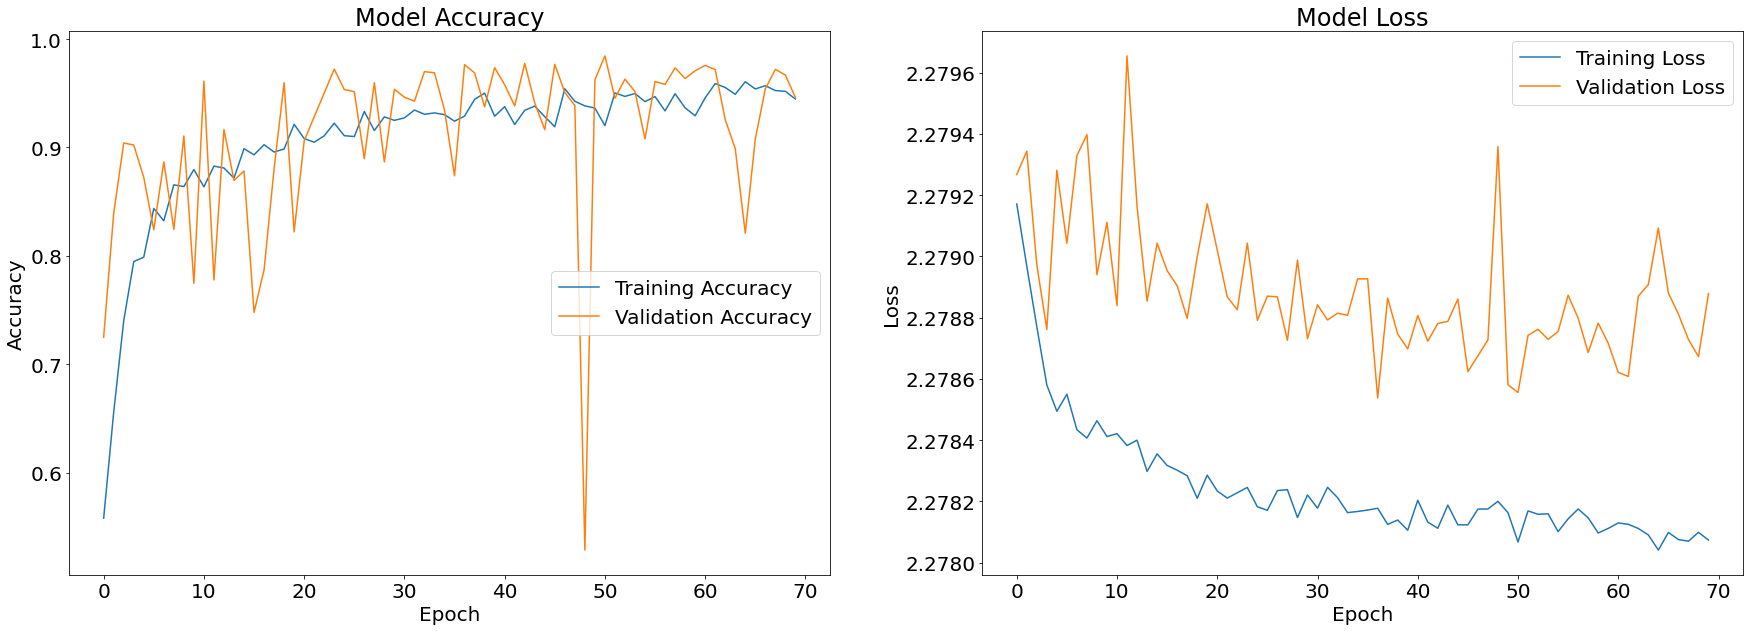

In [42]:

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams["font.size"] = 20

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['my_accuracy_9'])
ax[0].plot(history.history['val_my_accuracy_9'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show()

In [ ]:
#m.save("/content/drive/MyDrive/WeightsMnist/save.tf", save_format='tf')

# 
#!rm -f "/content/drive/MyDrive/WeightsMnist/save3.tf"

rm: cannot remove '/content/drive/MyDrive/WeightsMnist/save3.tf': Is a directory


In [43]:
basemodel_file = m.save("/content/drive/MyDrive/MnistResults/save_basemodel5.tf", save_format='tf')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MnistResults/save_basemodel5.tf/assets


In [37]:
# model = tf.keras.models.load_model("/content/drive/MyDrive/MnistResults/save_basemodel5.tf", 
#                                    custom_objects=\
#                           {\
#                               "SquashLayer": SquashLayer,\
#                               "SafeNorm": SafeNorm,\
#                               "MyDigitCapsLayer": MyDigitCapsLayer,
#                               "RoutingByAgreement": RoutingByAgreement,                      
#                               "MyAccuracy": MyAccuracy,                            
#                               "MarginLoss": MarginLoss
#                            })


mm = K.models.load_model('/content/drive/MyDrive/WeightsMnist/save2.tf',\
                         custom_objects=\
                          {\
                              "SquashLayer": SquashLayer,\
                              "SafeNorm": SafeNorm,\
                              "MyDigitCapsLayer": MyDigitCapsLayer,\
                              "RoutingByAgreement": RoutingByAgreement,\
                              "MyAccuracy": MyAccuracy,\
                              "MarginLoss": MarginLoss,\
                          })


TypeError: ignored

In [44]:
#Extra layer for evaluate
class DimensionCorrection(K.layers.Layer):
    def __init__(self, **kwargs):
      super(DimensionCorrection, self).__init__(**kwargs)
    
    def safe_norm(self, input, axis=-2, epsilon=1e-7, keep_dims=False, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

    def call(self,y_pred):
      y_proba = self.safe_norm(y_pred, axis=-2)
      y_proba_argmax = tf.argmax(y_proba, axis=2)
      y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
      return y_pred



In [ ]:
# y_test = tf.cast(y_test, dtype= tf.int64)
# print(y_test.shape)

In [45]:
m = Model.build()
m.load_weights('/content/drive/MyDrive/MnistResults/best_weights4.hdf5')
m.compile(optimizer='Adam', loss=MarginLoss)
newmodel = K.models.Sequential(\
            [\
            m,\
            DimensionCorrection(),\
            ]\
)
newmodel.summary()
m.trainable = False
newmodel.compile(optimizer='adam')

y_pred = newmodel.predict(x_test)

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
print(confusion_matrix(y_test, y_pred))
print(f"accuracy = {accuracy_score(y_test, y_pred)}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my (Functional)              (None, 1, 10, 16, 1)      6815744   
_________________________________________________________________
dimension_correction (Dimens (None,)                   0         
Total params: 6,815,744
Trainable params: 6,815,744
Non-trainable params: 0
_________________________________________________________________
[[ 973    1    1    0    0    0    3    1    1    0]
 [   0 1120    2    3    0    0    1    2    7    0]
 [   0    0 1027    0    0    0    0    4    1    0]
 [   0    0    3  999    0    1    0    4    3    0]
 [   1    0    1    0  954    0    5    1    2   18]
 [   1    0    2   20    0  857    7    2    3    0]
 [   5    2    0    0    1    1  948    0    1    0]
 [   0    3   13    2    0    0    0 1006    1    3]
 [   2    0    2    1    1    0    0    1  966    1]
 [   2    3    1    3    4    0

In [ ]:
# mm = K.models.load_model('/content/drive/MyDrive/WeightsMnist/save2.tf',\
#                          custom_objects=\
#                           {\
#                               "SquashLayer": SquashLayer,\
#                               "SafeNorm": SafeNorm,\
#                               "MyDigitCapsLayer": MyDigitCapsLayer,\
#                               "RoutingByAgreement": RoutingByAgreement,\
#                               "MyAccuracy": MyAccuracy,\
#                               "MarginLoss": MarginLoss,\
#                           })


In [ ]:
# y_pred_eval = DimensionCorrection()
# m2 = Model.build()
# m2.load_weights('/content/drive/MyDrive/WeightsMnist/latest_weights1.hdf5')





In [ ]:
# m3 = K.models.Sequential()
# m3.add(m2)
# m3.add(y_pred_eval)
# m3.build()
# m3.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
# m3.evaluate(x_test, y_test, batch_size= 32, verbose= 1)

# #m3.evaluate(x_test, y_test, batch_size= 32, verbose= 1)

In [ ]:
#converter = tf.lite.TFLiteConverter.from_keras_model(m)

In [ ]:
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# quantize_model = converter.convert()

In [ ]:
# mm = K.models.load_model('/content/drive/MyDrive/WeightsMnist/save2.tf',\
#                          custom_objects=\
#                           {\
#                               "SquashLayer": SquashLayer,\
#                               "SafeNorm": SafeNorm,\
#                               "MyDigitCapsLayer": MyDigitCapsLayer,\
#                               "RoutingByAgreement": RoutingByAgreement,\
#                               "MyAccuracy": MyAccuracy,\
#                               "MarginLoss": MarginLoss,\
#                           })
# print(type(mm), mm.summary())
# print(mm.weights[0][0][0][0][0:5])
# e = mm.load_weights('/content/drive/MyDrive/WeightsMnist/latest_weights1.hdf5')
# print(mm.weights[0][0][0][0][0:5])


# Create the .tflite file
# tflite_model_file = "/content/drive/MyDrive/WeightsMnist/compressed.tflite"
# converter = tf.lite.TFLiteConverter.from_keras_model(mm)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# ]

# tflite_model = converter.convert()
# with open(tflite_model_file, "wb") as f:
#     f.write(tflite_model)

In [ ]:
#checking for model 4
!du -sh /content/drive/MyDrive/MnistResults/*

27M	/content/drive/MyDrive/MnistResults/best_weights4.hdf5
11M	/content/drive/MyDrive/MnistResults/compressed1.tflite
27M	/content/drive/MyDrive/MnistResults/latest_weights1.hdf5
27M	/content/drive/MyDrive/MnistResults/latest_weights2.hdf5
27M	/content/drive/MyDrive/MnistResults/latest_weights3.hdf5
27M	/content/drive/MyDrive/MnistResults/latest_weights4.hdf5
512	/content/drive/MyDrive/MnistResults/mylogs1.csv
512	/content/drive/MyDrive/MnistResults/mylogs2.csv
512	/content/drive/MyDrive/MnistResults/mylogs3.csv
5.5K	/content/drive/MyDrive/MnistResults/mylogs4.csv
27M	/content/drive/MyDrive/MnistResults/pruned_file1.h5
27M	/content/drive/MyDrive/MnistResults/pruned_file2.h5
79M	/content/drive/MyDrive/MnistResults/save_basemode2.tf
79M	/content/drive/MyDrive/MnistResults/save_basemode3.tf
79M	/content/drive/MyDrive/MnistResults/save_basemodel4.tf
79M	/content/drive/MyDrive/MnistResults/save_basemodel.tf


# Use this tutorial for pruning
quantization has already been done earlier

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras


PRUNING


In [ ]:
# pip install -q tensorflow-model-optimization

In [49]:
comparison_metric.name


'my_accuracy_8'

In [50]:
comparisonmetric = MyAccuracy()
comparisonmetric.name

'my_accuracy_11'

In [51]:
import tensorflow_model_optimization as tfmot
import tempfile

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# TODO: Remove this line
#m.load_weights('/content/drive/MyDrive/MnistResults/best_weights4.hdf5')

# print("ORIGINAL MODEL")
# print(mm.summary())
# print('-' * 80)

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
finalSparsity = 0.60
list_finalSparsity = []
list_accuracy = []
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/best_weights5.hdf5')

  # Define model for pruning.
  # pruning_params = {
  #       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
  #                                                                final_sparsity=0.80,
  #                                                                begin_step=0,
  #                                                                end_step=end_step)
  # }

  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  """
  model_for_pruning = prune_low_magnitude(mm, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=MarginLoss(), metrics=[MyAccuracy()])

  model_for_pruning.summary()

  """


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  list_finalSparsity.append(finalSparsity)
  list_accuracy.append(f"{comparisonmetric.name}")
  finalSparsity+= 0.05

Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1688/1688 [==============================] - 73s 42ms/step - loss: 2.2779 - my_accuracy_12: 0.9839 - val_loss: 2.2753 - val_my_accuracy_12: 0.9832
Epoch 2/2
313/313 [==============================] - 11s 36ms/step - loss: 2.2767 - my_accuracy_12: 0.9827
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pru

In [55]:
finalSparsity = 0.15
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/best_weights5.hdf5')

  # Define model for pruning.
  # pruning_params = {
  #       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
  #                                                                final_sparsity=0.80,
  #                                                                begin_step=0,
  #                                                                end_step=end_step)
  # }

  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  """
  model_for_pruning = prune_low_magnitude(mm, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=MarginLoss(), metrics=[MyAccuracy()])

  model_for_pruning.summary()

  """


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  list_finalSparsity.append(finalSparsity)
  list_accuracy.append(model_for_pruning_accuracy)
  finalSparsity+= 0.05

Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 74s 43ms/step - loss: 2.2778 - my_accuracy_19: 0.9854 - val_loss: 2.2753 - val_my_accuracy_19: 0.9853
Epoch 2/2
313/313 [==============================] - 11s 35ms/step - loss: 2.2766 - my_accuracy_19: 0.9849
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning
Epoch 1/2
1688/1688 [==============================] - 77s 44ms/step - loss: 2.2778 - my_accuracy_20: 0.9854 - val_loss: 2.2753 - val

In [58]:
print(list_finalSparsity)

[0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002]


In [59]:
finalSparsity = 0.25
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/best_weights5.hdf5')

  # Define model for pruning.
  # pruning_params = {
  #       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
  #                                                                final_sparsity=0.80,
  #                                                                begin_step=0,
  #                                                                end_step=end_step)
  # }

  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.20,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  """
  model_for_pruning = prune_low_magnitude(mm, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=MarginLoss(), metrics=[MyAccuracy()])

  model_for_pruning.summary()

  """


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  list_finalSparsity.append(finalSparsity)
  list_accuracy.append(model_for_pruning_accuracy)
  print(f"prunned accuracy at final sparsity {finalSparsity} is {model_for_pruning_accuracy}")
  finalSparsity+= 0.05

Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 75s 43ms/step - loss: 2.2778 - my_accuracy_35: 0.9855 - val_loss: 2.2753 - val_my_accuracy_35: 0.9855
Epoch 2/2
313/313 [==============================] - 11s 34ms/step - loss: 2.2766 - my_accuracy_35: 0.9848
prunned accuracy at final sparsity 0.25 is 0.9847999811172485
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning
Epoch 1/2
1688/1688 [==============================] - 75s 44ms/step - 

In [60]:
list_accuracy30 = []
finalSparsity = 0.35
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/best_weights5.hdf5')

  # Define model for pruning.
  # pruning_params = {
  #       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
  #                                                                final_sparsity=0.80,
  #                                                                begin_step=0,
  #                                                                end_step=end_step)
  # }

  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  """
  model_for_pruning = prune_low_magnitude(mm, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=MarginLoss(), metrics=[MyAccuracy()])

  model_for_pruning.summary()

  """


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  
  list_accuracy30.append(model_for_pruning_accuracy)
  print(f"prunned accuracy at final sparsity {finalSparsity} is {model_for_pruning_accuracy}")
  finalSparsity+= 0.05

Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 75s 44ms/step - loss: 2.2778 - my_accuracy_49: 0.9855 - val_loss: 2.2753 - val_my_accuracy_49: 0.9857
Epoch 2/2
313/313 [==============================] - 11s 34ms/step - loss: 2.2766 - my_accuracy_49: 0.9852
prunned accuracy at final sparsity 0.35 is 0.9851999878883362
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning
Epoch 1/2
1688/1688 [==============================] - 77s 45ms/step - 

In [62]:
print(list_accuracy30)

[0.9851999878883362, 0.9850000143051147, 0.9850999712944031, 0.9855999946594238, 0.9848999977111816, 0.9825999736785889, 0.9776999950408936, 0.9570000171661377, 0.8522999882698059, 0.656499981880188, 0.4214000105857849, 0.29820001125335693]


In [61]:
list_accuracy40 = []
finalSparsity = 0.45
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/best_weights5.hdf5')

  # Define model for pruning.
  # pruning_params = {
  #       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
  #                                                                final_sparsity=0.80,
  #                                                                begin_step=0,
  #                                                                end_step=end_step)
  # }

  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.40,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  """
  model_for_pruning = prune_low_magnitude(mm, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=MarginLoss(), metrics=[MyAccuracy()])

  model_for_pruning.summary()

  """


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  
  list_accuracy40.append(model_for_pruning_accuracy)
  print(f"prunned accuracy at final sparsity {finalSparsity} is {model_for_pruning_accuracy}")
  finalSparsity+= 0.05

Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 76s 44ms/step - loss: 2.2778 - my_accuracy_61: 0.9854 - val_loss: 2.2753 - val_my_accuracy_61: 0.9853
Epoch 2/2
313/313 [==============================] - 11s 34ms/step - loss: 2.2766 - my_accuracy_61: 0.9851
prunned accuracy at final sparsity 0.45 is 0.9850999712944031
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning
Epoch 1/2
1688/1688 [==============================] - 76s 44ms/step - 

In [63]:
list_accuracy60 = []
finalSparsity = 0.65
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/best_weights5.hdf5')

  # Define model for pruning.
  # pruning_params = {
  #       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
  #                                                                final_sparsity=0.80,
  #                                                                begin_step=0,
  #                                                                end_step=end_step)
  # }

  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.60,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  """
  model_for_pruning = prune_low_magnitude(mm, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=MarginLoss(), metrics=[MyAccuracy()])

  model_for_pruning.summary()

  """


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  
  list_accuracy60.append(model_for_pruning_accuracy)
  print(f"prunned accuracy at final sparsity {finalSparsity} is {model_for_pruning_accuracy}")
  finalSparsity+= 0.05

Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 77s 44ms/step - loss: 2.2780 - my_accuracy_71: 0.9791 - val_loss: 2.2753 - val_my_accuracy_71: 0.9793
Epoch 2/2
313/313 [==============================] - 11s 36ms/step - loss: 2.2768 - my_accuracy_71: 0.9775
prunned accuracy at final sparsity 0.65 is 0.9775000214576721
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning
Epoch 1/2
1688/1688 [==============================] - 77s 45ms/step - 

In [64]:
print(list_accuracy60)

[0.9775000214576721, 0.9569000005722046, 0.8522999882698059, 0.6570000052452087, 0.4214000105857849, 0.29820001125335693]


In [65]:
list_accuracy70 = []
finalSparsity = 0.75
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/best_weights5.hdf5')

  # Define model for pruning.
  # pruning_params = {
  #       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
  #                                                                final_sparsity=0.80,
  #                                                                begin_step=0,
  #                                                                end_step=end_step)
  # }

  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.70,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  """
  model_for_pruning = prune_low_magnitude(mm, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=MarginLoss(), metrics=[MyAccuracy()])

  model_for_pruning.summary()

  """


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  
  list_accuracy70.append(model_for_pruning_accuracy)
  print(f"prunned accuracy at final sparsity {finalSparsity} is {model_for_pruning_accuracy}")
  finalSparsity+= 0.05

Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 77s 44ms/step - loss: 2.2794 - my_accuracy_77: 0.8681 - val_loss: 2.2764 - val_my_accuracy_77: 0.8645
Epoch 2/2
313/313 [==============================] - 11s 34ms/step - loss: 2.2784 - my_accuracy_77: 0.8521
prunned accuracy at final sparsity 0.75 is 0.8521000146865845
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning
Epoch 1/2
1688/1688 [==============================] - 74s 43ms/step - 

In [66]:
list_accuracy50 = []
finalSparsity = 0.55
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/best_weights5.hdf5')

  # Define model for pruning.
  # pruning_params = {
  #       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
  #                                                                final_sparsity=0.80,
  #                                                                begin_step=0,
  #                                                                end_step=end_step)
  # }

  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  """
  model_for_pruning = prune_low_magnitude(mm, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=MarginLoss(), metrics=[MyAccuracy()])

  model_for_pruning.summary()

  """


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  
  list_accuracy50.append(model_for_pruning_accuracy)
  print(f"prunned accuracy at final sparsity {finalSparsity} is {model_for_pruning_accuracy}")
  finalSparsity+= 0.05

Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 78s 45ms/step - loss: 2.2778 - my_accuracy_81: 0.9856 - val_loss: 2.2753 - val_my_accuracy_81: 0.9850
Epoch 2/2
313/313 [==============================] - 11s 37ms/step - loss: 2.2766 - my_accuracy_81: 0.9849
prunned accuracy at final sparsity 0.55 is 0.9848999977111816
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning
Epoch 1/2
1688/1688 [==============================] - 77s 44ms/step - 

In [68]:
list_accuracy0 = []
finalSparsity = 0.05
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/best_weights5.hdf5')

  # Define model for pruning.
  # pruning_params = {
  #       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
  #                                                                final_sparsity=0.80,
  #                                                                begin_step=0,
  #                                                                end_step=end_step)
  # }

  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  """
  model_for_pruning = prune_low_magnitude(mm, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=MarginLoss(), metrics=[MyAccuracy()])

  model_for_pruning.summary()

  """


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  
  list_accuracy0.append(model_for_pruning_accuracy)
  print(f"prunned accuracy at final sparsity {finalSparsity} is {model_for_pruning_accuracy}")
  finalSparsity+= 0.05

Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 76s 44ms/step - loss: 2.2778 - my_accuracy_89: 0.9854 - val_loss: 2.2753 - val_my_accuracy_89: 0.9853
Epoch 2/2
313/313 [==============================] - 11s 35ms/step - loss: 2.2766 - my_accuracy_89: 0.9850
prunned accuracy at final sparsity 0.05 is 0.9850000143051147
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0103b3c90> conv_layer_1 slated for pruning
Layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe070370210> conv_layer_2 slated for pruning
Layer <tensorflow.python.keras.layers.core.Reshape object at 0x7fe0672d4fd0> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7fe0701c7910> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7fdfdf8e5b10> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7fe010011ad0> routing1 slated for pruning
Epoch 1/2
1688/1688 [==============================] - 77s 44ms/step - 

In [1]:

print(list_accuracy30)
print(list_accuracy40)
print(list_accuracy50)
print(list_accuracy60)
print(list_accuracy70)

NameError: ignored


#explanation for increase in parameters after pruning

https://www.dlology.com/blog/how-to-compress-your-keras-model-x5-smaller-with-tensorflow-model-optimization/

In [ ]:
# _, model_for_pruning_accuracy = model_for_pruning.evaluate(
#    x_test, y_test, verbose=1)

313/313 [==============================] - 11s 34ms/step - loss: 2.2769 - my_accuracy_72: 0.5371


In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()
pruned_keras_file = "/content/drive/MyDrive/MnistResults/pruned_file4_60.h5"
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Model: "my"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 20, 20, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 1152, 8)           0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 1152, 8)           0         
_________________________________________________________________
caps2_predicted (MyDigitCaps (None, 1152, 10, 16, 1)   1474560   
_________________________________________________________________
routing1 (RoutingByAgreement (None, 1, 10, 16, 1)      11520    

In [ ]:
!du -sh /content/drive/MyDrive/MnistResults/*

27M	/content/drive/MyDrive/MnistResults/best_weights4.hdf5
11M	/content/drive/MyDrive/MnistResults/compressed1.tflite
27M	/content/drive/MyDrive/MnistResults/latest_weights1.hdf5
27M	/content/drive/MyDrive/MnistResults/latest_weights2.hdf5
27M	/content/drive/MyDrive/MnistResults/latest_weights3.hdf5
27M	/content/drive/MyDrive/MnistResults/latest_weights4.hdf5
512	/content/drive/MyDrive/MnistResults/mylogs1.csv
512	/content/drive/MyDrive/MnistResults/mylogs2.csv
512	/content/drive/MyDrive/MnistResults/mylogs3.csv
5.5K	/content/drive/MyDrive/MnistResults/mylogs4.csv
27M	/content/drive/MyDrive/MnistResults/pruned_file1.h5
27M	/content/drive/MyDrive/MnistResults/pruned_file2.h5
27M	/content/drive/MyDrive/MnistResults/pruned_file4_30.h5
27M	/content/drive/MyDrive/MnistResults/pruned_file4_60.h5
79M	/content/drive/MyDrive/MnistResults/save_basemode2.tf
79M	/content/drive/MyDrive/MnistResults/save_basemode3.tf
79M	/content/drive/MyDrive/MnistResults/save_basemodel4.tf
79M	/content/drive/MyDri

In [ ]:
from tensorflow.keras.models import load_model

model = model_for_export
import numpy as np

for i, w in enumerate(model.get_weights()):
  print("{} -- Total:{}, Zeros: {:.2f}%".format(model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100))
    

conv_layer_1/kernel:0 -- Total:20736, Zeros: 0.00%
conv_layer_1/bias:0 -- Total:256, Zeros: 0.00%
conv_layer_2/kernel:0 -- Total:5308416, Zeros: 80.00%
conv_layer_2/bias:0 -- Total:256, Zeros: 0.00%
caps2_predicted/kernel:0 -- Total:1474560, Zeros: 80.00%
routing1/raw_weights:0 -- Total:11520, Zeros: 0.00%


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmpkdyfje3e/assets


AttributeError: ignored

tyoes of post training quantization
https://www.tensorflow.org/lite/performance/post_training_quantization

In [ ]:
#converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model_file = "/content/drive/MyDrive/MnistResults/compressed2.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: /tmp/tmpb1h9c4wq/assets


In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(basemodel_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(tflite_model_file)))

Size of gzipped pruned Keras model: 8135771.00 bytes
Size of gzipped pruned TFlite model: 3345362.00 bytes


In [ ]:
!du -sh /content/drive/MyDrive/MnistResults/*

11M	/content/drive/MyDrive/MnistResults/compressed1.tflite
27M	/content/drive/MyDrive/MnistResults/latest_weights1.hdf5
512	/content/drive/MyDrive/MnistResults/mylogs1.csv
27M	/content/drive/MyDrive/MnistResults/pruned_file1.h5
79M	/content/drive/MyDrive/MnistResults/save_basemodel.tf
